# Shuffle Analysis

Because we are identifying overlaps between human and macaque, overlaps could arise by chance rather than be influenced by biology. To address this possibility, I am doing an analysis here that I am calling "shuffle analysis". For this analysis I will compare the number of overlaps we obtain for HH vs MM (2,397) with that of overlaps when I shuffle MM regions in the analytic genomic space (shared accessible chromatin). The hypothesis is we should see greater a greater observed overlap than is expected by chance.  

## Make new config section

In [2]:
#function
append_section_to_ini <- function(ini_file, new_section) {
    if (is.list(new_section)) {
        ini <- ini::read.ini(ini_file)
        ini <- c(ini,new_section)
        ini::write.ini(x=ini, filepath=ini_file)
    } else {
        print('new_section is not a list')
    }
}

#list of key-value pairs
TH_SHUFFLE <- list(dir='/data/hodges_lab/ATAC-STARR_B-cells/results/results_human-evolution/TH_shuffle', 
               mm_shuffles_dir='/data/hodges_lab/ATAC-STARR_B-cells/results/results_human-evolution/TH_shuffle/mm_shuffles', 
               shuffle_overlap='/data/hodges_lab/ATAC-STARR_B-cells/results/results_human-evolution/TH_shuffle/expected_overlap.txt', 
               plots='/data/hodges_lab/ATAC-STARR_B-cells/results/results_human-evolution/TH_shuffle/plots', 
               bin='/data/hodges_lab/ATAC-STARR_B-cells/bin_human-evolution/processing-and-region-calling/shuffle_analysis.ipynb')

#list of section, resulting in list of list.
new_section <- list(TH_SHUFFLE =TH_SHUFFLE)

#write ini
append_section_to_ini("../config.ini", new_section)

## Make MM shuffles

In [1]:
# bash kernel
#input
MM=$(read-ini ../config.ini ACTIVITY mm_active_regions)
SHARED_ACC=$(read-ini ../config.ini CHRACC shared_peaks)

#ouput
out_dir=$(read-ini ../config.ini TH_SHUFFLE mm_shuffles_dir)

In [2]:
for i in {1..1000}
do
    bedtools shuffle -noOverlapping -incl $SHARED_ACC -i $MM -g /home/hansetj1/chrom.sizes/hg38.chrom.sizes \
    > ${out_dir}/mm_shuffle_${i}.bed
done

## Intersect shuffles with HH

In [6]:
#input
HH=$(read-ini ../config.ini ACTIVITY hh_active_regions)
in_dir=$(read-ini ../config.ini TH_SHUFFLE mm_shuffles_dir)

#ouput
EXPECTED=$(read-ini ../config.ini TH_SHUFFLE shuffle_overlap)

In [9]:
rm $EXPECTED # need to delete otherwise will continue to write the previous file, if re-run. 

for i in {1..1000}
do
   bedtools intersect -f 0.5 -F 0.5 -e -a $HH -b ${in_dir}/mm_shuffle_${i}.bed | wc -l >> $EXPECTED 
done

In [10]:
bedtools intersect -f 0.5 -F 0.5 -e -a $HH -b $MM | wc -l 

3104


## Plot results

In [1]:
suppressPackageStartupMessages(library(tidyverse))

ini <- ini::read.ini("../config.ini")

In [2]:
expected <- read_tsv(ini$TH_SHUFFLE$shuffle_overlap, col_names = c("count"))
observed <- 3104

Rows: 1000 Columns: 1

── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
dbl (1): count


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



In [6]:
p <- ggplot(expected, aes(x = count)) +
    geom_density(fill = "steelblue", color = "white") +
    geom_vline(xintercept = observed, color = "firebrick") +
    scale_y_continuous(breaks = c(0, 0.01, 0.02)) +
    labs(x = "number of overlaps", title = "Observed vs. Expected HH-MM active overlaps") +
    theme_bw(base_size = 10) +
    theme(plot.title = element_text(hjust = 0.5, size = 10)) +
    coord_cartesian(xlim = c(0, 3500))

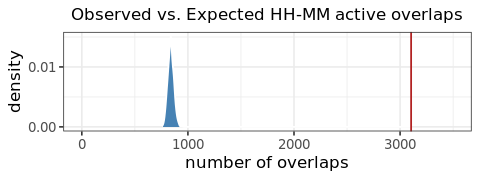

In [7]:
options(repr.plot.width = 4, repr.plot.height = 1.5)
p

In [8]:
ggsave(p, filename = paste0(ini$TH_SHUFFLE$plots, "/HH-vs-MM_observed-expected_density.pdf"), 
       device = cairo_pdf, width = 4, height = 1.5)

## Stats: Grubb's Test for Outliers

In [9]:
# do the stats
all <- as.integer(expected$count) %>% append(values = observed)

In [10]:
outliers::grubbs.test(all, type = 10, opposite = FALSE, two.sided = FALSE)


	Grubbs test for one outlier

data:  all
G = 29.43111, U = 0.13294, p-value < 2.2e-16
alternative hypothesis: highest value 3104 is an outlier


## Repeat for cis and trans effects

### Make HM and MH shuffles

In [1]:
# bash kernel
#input
HM=$(read-ini ../config.ini ACTIVITY hm_active_regions)
MH=$(read-ini ../config.ini ACTIVITY mh_active_regions)
SHARED_ACC=$(read-ini ../config.ini CHRACC shared_peaks)

#ouput
out_dir=$(read-ini ../config.ini TH_SHUFFLE dir)

In [2]:
mkdir ${out_dir}/hm_shuffles
mkdir ${out_dir}/mh_shuffles

#HM
for i in {1..1000}
do
    bedtools shuffle -noOverlapping -incl $SHARED_ACC -i $HM -g /home/hansetj1/chrom.sizes/hg38.chrom.sizes \
    > ${out_dir}/hm_shuffles/hm_shuffle_${i}.bed
done

#MH
for i in {1..1000}
do
    bedtools shuffle -noOverlapping -incl $SHARED_ACC -i $MH -g /home/hansetj1/chrom.sizes/hg38.chrom.sizes \
    > ${out_dir}/mh_shuffles/mh_shuffle_${i}.bed
done

mkdir: cannot create directory ‘/data/hodges_lab/ATAC-STARR_B-cells/results/results_human-evolution/TH_shuffle/hm_shuffles’: File exists
mkdir: cannot create directory ‘/data/hodges_lab/ATAC-STARR_B-cells/results/results_human-evolution/TH_shuffle/mh_shuffles’: File exists


### Intersect MH shuffles with HH_specific - HH_cis

In [3]:
#input
HH_specific=$(read-ini ../config.ini HH-VS-MM hh-active_mm-inactive)
MH=$(read-ini ../config.ini ACTIVITY mh_active_regions)
out_dir=$(read-ini ../config.ini TH_SHUFFLE dir)

#ouput
EXPECTED=$(read-ini ../config.ini TH_SHUFFLE dir)

In [4]:
rm ${EXPECTED}/HH_cis_expected.txt # need to delete otherwise will continue to write the previous file, if re-run. 

for i in {1..1000}
do
   bedtools intersect -f 0.5 -F 0.5 -e -a $HH_specific -b ${out_dir}/mh_shuffles/mh_shuffle_${i}.bed | wc -l >> ${EXPECTED}/HH_cis_expected.txt
done

In [6]:
#calcuate observed
bedtools intersect -f 0.5 -F 0.5 -e -a $HH_specific -b $MH | wc -l 

1187


In [1]:
suppressPackageStartupMessages(library(tidyverse))
ini <- ini::read.ini("../config.ini")
expected <- read_tsv(paste0(ini$TH_SHUFFLE$dir, "/HH_cis_expected.txt"), col_names = c("count"), show_col_types = FALSE)
observed <- 1187

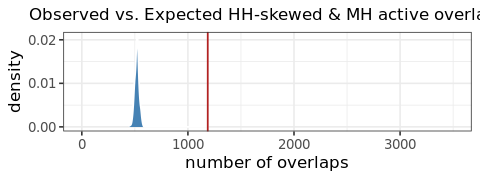

In [3]:
p <- ggplot(expected, aes(x = count)) +
    geom_density(fill = "steelblue", color = "white") +
    geom_vline(xintercept = observed, color = "firebrick") +
    scale_y_continuous(breaks = c(0, 0.01, 0.02)) +
    labs(x = "number of overlaps", title = "Observed vs. Expected HH-skewed & MH active overlaps") +
    theme_bw(base_size = 10) +
    theme(plot.title = element_text(hjust = 0.5, size = 10)) +
    coord_cartesian(xlim = c(0, 3500))

options(repr.plot.width = 4, repr.plot.height = 1.5)
p

ggsave(p, filename = paste0(ini$TH_SHUFFLE$plots, "/HH-cis_observed-expected_density.pdf"), 
       device = cairo_pdf, width = 4, height = 1.5)

In [4]:
# do the stats
all <- as.integer(expected$count) %>% append(values = observed)
outliers::grubbs.test(all, type = 10, opposite = FALSE, two.sided = FALSE)


	Grubbs test for one outlier

data:  all
G = 22.45283, U = 0.49537, p-value < 2.2e-16
alternative hypothesis: highest value 1187 is an outlier


### Intersect HM shuffles with MM_specific - MM_cis

In [1]:
#input
MM_specific=$(read-ini ../config.ini HH-VS-MM mm-active_hh-inactive)
HM=$(read-ini ../config.ini ACTIVITY hm_active_regions)
out_dir=$(read-ini ../config.ini TH_SHUFFLE dir)

#ouput
EXPECTED=$(read-ini ../config.ini TH_SHUFFLE dir)

In [2]:
rm ${EXPECTED}/MM_cis_expected.txt # need to delete otherwise will continue to write the previous file, if re-run. 

for i in {1..1000}
do
   bedtools intersect -f 0.5 -F 0.5 -e -a $MM_specific -b ${out_dir}/hm_shuffles/hm_shuffle_${i}.bed | wc -l >> ${EXPECTED}/MM_cis_expected.txt
done

In [3]:
#calcuate observed
bedtools intersect -f 0.5 -F 0.5 -e -a $MM_specific -b $HM | wc -l 

1921


In [1]:
suppressPackageStartupMessages(library(tidyverse))
ini <- ini::read.ini("../config.ini")
expected <- read_tsv(paste0(ini$TH_SHUFFLE$dir, "/MM_cis_expected.txt"), col_names = c("count"), show_col_types = FALSE)
observed <- 1921

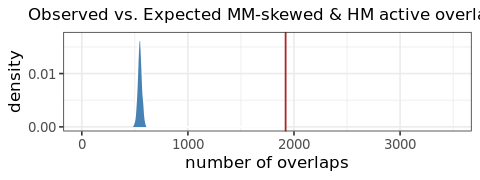

In [2]:
p <- ggplot(expected, aes(x = count)) +
    geom_density(fill = "steelblue", color = "white") +
    geom_vline(xintercept = observed, color = "firebrick") +
    scale_y_continuous(breaks = c(0, 0.01, 0.02)) +
    labs(x = "number of overlaps", title = "Observed vs. Expected MM-skewed & HM active overlaps") +
    theme_bw(base_size = 10) +
    theme(plot.title = element_text(hjust = 0.5, size = 10)) +
    coord_cartesian(xlim = c(0, 3500))

options(repr.plot.width = 4, repr.plot.height = 1.5)
p

ggsave(p, filename = paste0(ini$TH_SHUFFLE$plots, "/MM-cis_observed-expected_density.pdf"), 
       device = cairo_pdf, width = 4, height = 1.5)

In [3]:
# do the stats
all <- as.integer(expected$count) %>% append(values = observed)
outliers::grubbs.test(all, type = 10, opposite = FALSE, two.sided = FALSE)


	Grubbs test for one outlier

data:  all
G = 28.16288, U = 0.20606, p-value < 2.2e-16
alternative hypothesis: highest value 1921 is an outlier


### Intersect HM shuffles with HH_specific - HH_trans

In [4]:
#input
HH_specific=$(read-ini ../config.ini HH-VS-MM hh-active_mm-inactive)
HM=$(read-ini ../config.ini ACTIVITY hm_active_regions)
out_dir=$(read-ini ../config.ini TH_SHUFFLE dir)

#ouput
EXPECTED=$(read-ini ../config.ini TH_SHUFFLE dir)

In [5]:
rm ${EXPECTED}/HH_trans_expected.txt # need to delete otherwise will continue to write the previous file, if re-run. 

for i in {1..1000}
do
   bedtools intersect -f 0.5 -F 0.5 -e -a $HH_specific -b ${out_dir}/hm_shuffles/hm_shuffle_${i}.bed | wc -l >> ${EXPECTED}/HH_trans_expected.txt
done

In [6]:
#calcuate observed
bedtools intersect -f 0.5 -F 0.5 -e -a $HH_specific -b $HM | wc -l 

1489


In [4]:
suppressPackageStartupMessages(library(tidyverse))
ini <- ini::read.ini("../config.ini")
expected <- read_tsv(paste0(ini$TH_SHUFFLE$dir, "/HH_trans_expected.txt"), col_names = c("count"), show_col_types = FALSE)
observed <- 1489

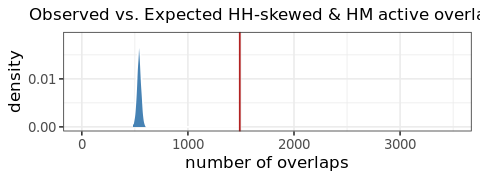

In [5]:
p <- ggplot(expected, aes(x = count)) +
    geom_density(fill = "steelblue", color = "white") +
    geom_vline(xintercept = observed, color = "firebrick") +
    scale_y_continuous(breaks = c(0, 0.01, 0.02)) +
    labs(x = "number of overlaps", title = "Observed vs. Expected HH-skewed & HM active overlaps") +
    theme_bw(base_size = 10) +
    theme(plot.title = element_text(hjust = 0.5, size = 10)) +
    coord_cartesian(xlim = c(0, 3500))

options(repr.plot.width = 4, repr.plot.height = 1.5)
p

ggsave(p, filename = paste0(ini$TH_SHUFFLE$plots, "/HH-trans_observed-expected_density.pdf"), 
       device = cairo_pdf, width = 4, height = 1.5)

In [6]:
# do the stats
all <- as.integer(expected$count) %>% append(values = observed)
outliers::grubbs.test(all, type = 10, opposite = FALSE, two.sided = FALSE)


	Grubbs test for one outlier

data:  all
G = 25.62984, U = 0.34245, p-value < 2.2e-16
alternative hypothesis: highest value 1489 is an outlier


### Intersect MH shuffles with MM_specific - MM_trans

In [ ]:
#input
MM_specific=$(read-ini ../config.ini HH-VS-MM mm-active_hh-inactive)
MH=$(read-ini ../config.ini ACTIVITY mh_active_regions)
out_dir=$(read-ini ../config.ini TH_SHUFFLE dir)

#ouput
EXPECTED=$(read-ini ../config.ini TH_SHUFFLE dir)

In [8]:
rm ${EXPECTED}/MM_trans_expected.txt # need to delete otherwise will continue to write the previous file, if re-run. 

for i in {1..1000}
do
   bedtools intersect -f 0.5 -F 0.5 -e -a $MM_specific -b ${out_dir}/mh_shuffles/mh_shuffle_${i}.bed | wc -l >> ${EXPECTED}/MM_trans_expected.txt
done

In [9]:
#calcuate observed
bedtools intersect -f 0.5 -F 0.5 -e -a $MM_specific -b $MH | wc -l 

1800


In [8]:
suppressPackageStartupMessages(library(tidyverse))
ini <- ini::read.ini("../config.ini")
expected <- read_tsv(paste0(ini$TH_SHUFFLE$dir, "/MM_trans_expected.txt"), col_names = c("count"), show_col_types = FALSE)
observed <- 1800

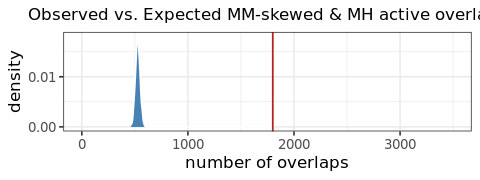

In [9]:
p <- ggplot(expected, aes(x = count)) +
    geom_density(fill = "steelblue", color = "white") +
    geom_vline(xintercept = observed, color = "firebrick") +
    scale_y_continuous(breaks = c(0, 0.01, 0.02)) +
    labs(x = "number of overlaps", title = "Observed vs. Expected MM-skewed & MH active overlaps") +
    theme_bw(base_size = 10) +
    theme(plot.title = element_text(hjust = 0.5, size = 10)) +
    coord_cartesian(xlim = c(0, 3500))

options(repr.plot.width = 4, repr.plot.height = 1.5)
p

ggsave(p, filename = paste0(ini$TH_SHUFFLE$plots, "/MM-trans_observed-expected_density.pdf"), 
       device = cairo_pdf, width = 4, height = 1.5)

In [10]:
# do the stats
all <- as.integer(expected$count) %>% append(values = observed)
outliers::grubbs.test(all, type = 10, opposite = FALSE, two.sided = FALSE)


	Grubbs test for one outlier

data:  all
G = 27.62658, U = 0.23601, p-value < 2.2e-16
alternative hypothesis: highest value 1800 is an outlier
